## Can You Predict Product Backorders?


### Project:
Ultimately, backordering boils down to having orders that you can’t fulfill or more orders than you have stock on hand. It’s a dream for any business but it’s also a huge problem if you don’t know how to handle it.
In this project we are trying to identify parts at risk of backorder before the event occurs so the business has time to react.

### Data:
Data is Based on historical data predict backorder risk for products
Training data file contains the historical data for the 8 weeks prior to the week we are trying to predict. 
The data was taken as weekly snapshots at the start of each week.
data is from kaggle :
https://www.kaggle.com/tiredgeek/predict-bo-trial/data

##### Data Wrangling and Cleaning:
The data come in the form of MS Excel spreadsheets, which are easily loaded into pandas dataframes.
in this data sets we have Yes/No fields which are converted in to binary integers.
-99 values in performance columns which are missing values and replaced by median.
we have some NaNs in lead_time but we are not sure that are missing or not.
It's quite likely that when lead_time is missing, it's missing for a reason and not at random, which means a mean/median imputation strategy may not be appropriate.
I prefer to decide by looking at data with calculationg the proportion of backordered products with vs. without a missing value in lead_time.
Since the data set is very big I decided to reduce data by capturing 60% of the total sales volume which is a big reduction in data for not much loss of fidelity.

##### Data Visualization
For data visualization I use transformation(square root) thats appropriate for heavy tailed data.

In [56]:
import decimal

import pandas as pd
import numpy as np

from scipy import stats

from sklearn.preprocessing import Imputer
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

In [57]:
#train_data_=train_data


In [58]:
backorder_file = pd.read_csv("Kaggle_Training_Dataset_v2.csv")

orders = (backorder_file
              .drop(backorder_file.index[len(backorder_file)-1])# drop invalid last row
              .replace(['Yes', 'No'], [1, 0]))               # make yes/no numeric

C:\Users\Hedi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
orders.tail()
#data Information
orders.info()
#data description
orders.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
sku                  1687860 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null int64
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null int64
oe_constraint        1687860 non-null int64
ppap_risk           

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,...,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,...,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01,2.295706e-01,1.451542e-04,1.207648e-01,9.638086e-01,4.330928e-04,6.690721e-03
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,...,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01,4.205568e-01,1.204713e-02,3.258538e-01,1.867661e-01,2.080638e-02,8.152275e-02
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,...,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,...,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,...,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Data Preparation

In [60]:
#missing values in product
orders.sku.isnull().sum()

0

In [61]:
#missing value 
orders.isnull().sum()

sku                       0
national_inv              0
lead_time            100893
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [62]:
#replacing -99 missing values to median
imp=Imputer(missing_values=-99,strategy='median')
for data in ['perf_6_month_avg','perf_12_month_avg']:
    orders[data] = imp.fit_transform(orders[data].values.reshape(-1, 1))

### EDA

In [88]:
#backorder ratio
prob=len(orders[orders.went_on_backorder==1])/len(orders.sku)
print((prob*100),'%')
print(len(orders[orders.went_on_backorder==1]))


0.6690720794378681 %
11293


check the missing data in lead time to replace it or not?
1. Proportion of orders that “went_on_backorder” for missing lead_time records
2. Proportion of orders that “went_on_backorder” for non-null lead_time records

In [98]:
n_null_leadTime = orders[orders['lead_time'].isnull()].shape[0]
print ('number of orders with missing lead time:', orders[orders['lead_time'].isnull()].shape[0])
n_non_null_leadTime = orders[orders['lead_time'].notnull()].shape[0]
print ('number of orders without missing lead time:',orders[orders['lead_time'].notnull()].shape[0])
n_null_leadTime_backorders =sum(orders[np.isnan(orders["lead_time"])]["went_on_backorder"])
print ('Number of backordered products with misssing lead time:', n_null_leadTime_backorders)
n_non_null_leadTime_backorders = sum(orders[pd.notnull(orders["lead_time"])]["went_on_backorder"])
print  ('Number of backordered products without misssing lead time:',n_non_null_leadTime_backorders)
print ('Total orders went on backorders:',n_null_leadTime_backorders+ n_non_null_leadTime_backorders)

null_leadTime_backorder_ratio = n_null_leadTime_backorders / float(n_null_leadTime)
non_null_leadTime_backorder_ratio = n_non_null_leadTime_backorders / float(n_non_null_leadTime)
print('Proportion of orders without missing lead time that went_on_backorder:',non_null_leadTime_backorder_ratio * 100)
print('Proportion of orders with missing lead_time that went_on_backorder :', null_leadTime_backorder_ratio * 100)


number of orders with missing lead time: 100893
number of orders without missing lead time: 1586967
Number of backordered products with misssing lead time: 324
Number of backordered products without misssing lead time: 10969
Total orders went on backorders: 11293
Proportion of orders without missing lead time that went_on_backorder: 0.691192696508
Proportion of orders with missing lead_time that went_on_backorder : 0.321132288662


Based on the above calculations the proportion of backordered products with missing lead time is 50% less than those without missing lead time.
The proportion of backordere products with missing lead time is half of the products with no missing values, therefore I decided not to replace the missing data in lead time and not dropiing them.
Plot below shows the density of products for a given lead time that went on backorder and did not go on backorder.

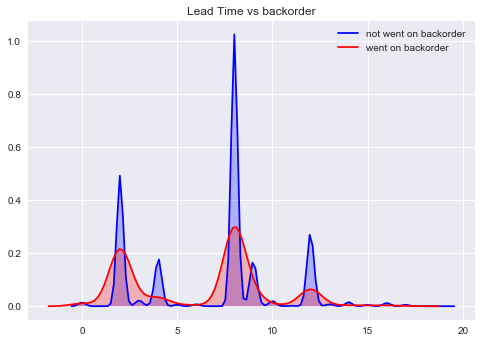

In [100]:
#Relationship between lead time and went on backorder
sns.kdeplot(orders[(orders['went_on_backorder'] == 0) & (orders['lead_time'] < 20)]['lead_time'],color='b', shade=True,label='not went on backorder')
sns.kdeplot(orders[(orders['went_on_backorder'] == 1) & (orders['lead_time'] < 20)]['lead_time'], color='r',shade=True,label='went on backorder')
plt.title('Lead Time vs backorder')
plt.show()

I can see that both lead time with back order and not backorder both peak for the same Lead time. However, the backorder graph is lower than no backorder graph.
Therefore I am going to see if lead time and went on backorder are independent or dependent from each other.
the next step is looking at the relationship between lead time and fraction of products that went on backorder to see how lead time changes the probability of went to backorder.

Plot below shows the relation between lead time and the fraction of backorder. The following plot shows with longer lead time, backorder proportion goes down.

[[ 1.        -0.5420028]
 [-0.5420028  1.       ]]


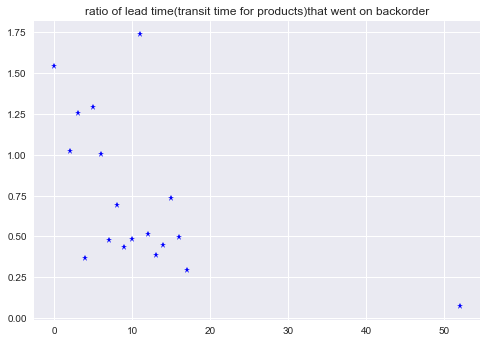

[1.5412425078489203, 1.0245938079797985, 1.2551528948501816, 0.36954339995487684, 1.2900024807740016, 1.006523765144455, 0.4784688995215311, 0.6954115153345275, 0.43348510703685433, 0.48618940248027059, 1.7367458866544789, 0.51276915373059584, 0.38852913968547642, 0.44599573395384917, 0.73452256033578167, 0.49756869840551843, 0.29231995748073347, 0.073058147643874735]


,lead_b,lead_n
0.0,162.0,10349
2.0,3457.0,333945
3.0,204.0,16049
4.0,475.0,128062
5.0,52.0,3979
6.0,54.0,5311
7.0,1.0,208
8.0,4744.0,677442
9.0,536.0,123113
10.0,69.0,14123


In [101]:
import decimal
b=orders[['went_on_backorder','lead_time']]
backorder=b[b.went_on_backorder==1]
no_backorder=b[b.went_on_backorder==0]
lead_b=backorder.lead_time.value_counts()
lead_n=no_backorder.lead_time.value_counts()
c=[]
df1 = pd.DataFrame(
    {
     'lead_b': lead_b,
     'lead_n':lead_n
    })

df1=df1[['lead_b','lead_n']].dropna()


for i in range(0,len(df1)):
    backorder_ratio=(df1.lead_b.iloc[i])/(df1.lead_n.iloc[i]+df1.lead_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    c.append(backorder_ratio)


print(np.corrcoef(df1.index.values,c))

plt.plot(df1.index.values,c,"*",color="blue")
plt.title('ratio of lead time(transit time for products)that went on backorder')
#plt.plot(np.array(range(len(c))) * 0.25, c,".")
plt.show()
print(c)
df1


In the above plot, two outlier are noticed. one is at lead time=11 and one at lead time 52. 
for the point on 52 I belive there was not enough records to show the rest of point between17 to 52.
the point at lead time 11 should be given special attention till its cause is known.
fo this reason I am going to calulate the probability bionomial distribution.

In [18]:
from scipy.stats import binom
import math
s = binom.pmf(19, 1094,0.01)
print(s)
sd=math.sqrt(1094 * 0.01 * (1 - 0.01))
print("Standard deviation ",sd)
print ((19 - 10.94)/sd)

0.00786682435841
3.2909876936871094
2.449112774095443


As you see from the above calculations standard deviation of bionomial distribution is 3.23 standard deviation from the mean so I am going to ignore this point 

### Data Reduction:
Cumulative percentage is one way of expressing frequency distribution. 


C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


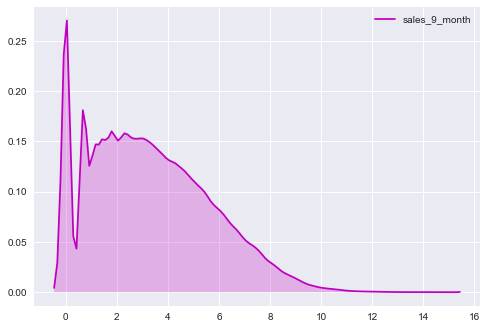

In [68]:
sales_sort=orders.sort_values('sales_9_month',ascending = False)
sns.kdeplot(np.log(sales_sort['sales_9_month']),color='m', shade=True)
plt.show()

[[ 1.          0.90766073]
 [ 0.90766073  1.        ]]


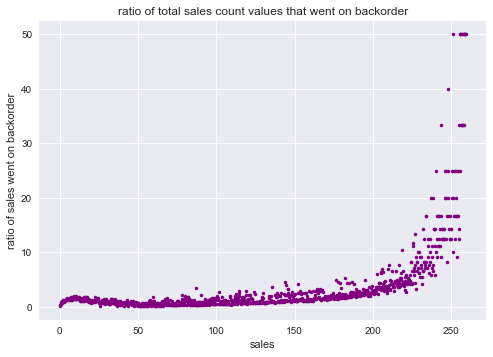

In [70]:
#relationship between sales and backorder
backorder_sales=sales_sort[sales_sort.went_on_backorder==1]
no_backorder_sales=sales_sort[sales_sort.went_on_backorder==0]
sales_b=backorder_sales.sales_9_month.value_counts()
sales_n=no_backorder_sales.sales_9_month.value_counts()
g=[]
df2 = pd.DataFrame(
    {
     'sales_b': sales_b,
     'sales_n':sales_n
    })

df2=df2[['sales_b','sales_n']].dropna()


for i in range(0,len(df2)):
    backorder_ratio=(df2.sales_b.iloc[i])/(df2.sales_n.iloc[i]+df2.sales_b.iloc[i])
    backorder_ratio=backorder_ratio*100
    g.append(backorder_ratio)


print(np.corrcoef(df2.index.values,g))
plt.plot(np.array(range(len(g))) * 0.25, g,".",color='purple')
plt.title('ratio of total sales count values that went on backorder')
plt.xlabel('sales')
plt.ylabel('ratio of sales went on backorder')
plt.show()


Data reduction by capture 60% of the total sales volume.

883338607.0
530003164.2


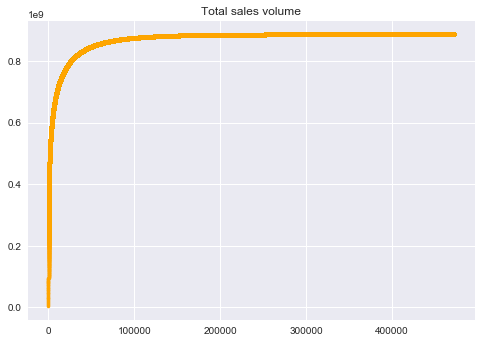

In [71]:
sales_volume =np.cumsum(sales_sort.sales_9_month)
print(sales_volume[len(sales_volume)-1])
print(0.6 * sales_volume[len(sales_volume)-1])
plt.plot(np.array(range(len(sales_sort))) * 0.28, sales_volume,".",color="orange")
plt.title('Total sales volume')

plt.show()

530003164.2
883338607.0


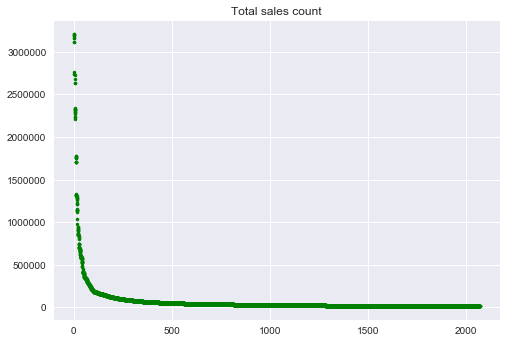

7397

In [82]:
volume_perc=0.6 * sales_volume[len(sales_volume)-1]
print(volume_perc)
print(sales_volume[len(sales_volume)-1])
sales_sort['sales_volume']=sales_volume

sales_sort=sales_sort.sort_values('sales_volume',ascending = True)
sales_sort=sales_sort[sales_sort['sales_volume']<=volume_perc]

sales_sort=sales_sort.sort_values('sales_9_month',ascending = False)
plt.plot(np.array(range(len(sales_sort))) * 0.28, sales_sort.sales_9_month,".",color="green")
plt.title('Total sales count')
plt.show()
len(sales_sort)

So with capturing 60% total sales volume ,data is reduced to 7509 rows.

In [85]:
print(sum(sales_sort[np.isnan(sales_sort["lead_time"])]["went_on_backorder"]))
print(sum(sales_sort.lead_time.isnull()))
print (sum(sales_sort[np.isnan(sales_sort["lead_time"])]["sales_9_month"]))
print (sum(sales_sort.sales_9_month))
print ((a/b)*100)

4
184
13581330.0
529994997.0
         went_on_backorder     lead_time
0                      inf           NaN
1                      inf  1.509037e+08
2                      inf           NaN
3                      inf  1.697666e+08
4                      inf           NaN
5                      inf  1.697666e+08
6                      inf           NaN
7                      inf  6.790665e+08
8                      inf           NaN
9                      inf  1.697666e+08
10                     inf  6.790665e+08
11                     inf           NaN
12                     inf           NaN
13                     inf           NaN
14                     inf           NaN
15                     inf  1.697666e+08
16                     inf  6.790665e+08
17                     inf  6.790665e+08
18                     inf           NaN
19                     inf  1.697666e+08
20                     inf           NaN
21                     inf           NaN
22                     inf  

C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


How common are backorders? Given that, how likely are backorders based on the part risk flags? 
And how prevalent are they? 
What is the relationship between "potential_issue" and "pieces_past_due" are each represented by part 
risk flags or are they unrelated concepts? What's the relationship between lead time and back orders? 
Based on the answers to these questions you could recommend: What aspects of the supply chain present the biggest risks? 
Based on the risks, what would you recommend improving first?
    
potential_issue - Source issue for part identified

pieces_past_due - Parts overdue from source

local_bo_qty - Amount of stock orders overdue

deck_risk - Part risk flag

oe_constraint - Part risk flag

ppap_risk - Part risk flag

In [105]:
print(np.corrcoef(orders.potential_issue,orders.pieces_past_due))
print('Source issue for part identified correlation with backorder',np.corrcoef(orders.potential_issue,orders.went_on_backorder))
print('Parts overdue from source correlation with backorder', np.corrcoef(orders.went_on_backorder,orders.pieces_past_due))
print('Amount of stock orders overdue correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.local_bo_qty))
print('oe_constraint - Part risk flag correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.oe_constraint))
print('ppap_risk - Part risk flag correlation with backorder', np.corrcoef(orders.went_on_backorder,orders.ppap_risk))
print('Total sales for perior 9,6,3 and 1 month correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.sales_9_month))
print('Total Forecast sales - Part risk flag correlation with backorder',np.corrcoef(orders.went_on_backorder,orders.forecast_9_month))
print('Total Forecast sales - Total Sales',np.corrcoef(orders.sales_9_month,orders.forecast_9_month))

[[ 1.          0.00331913]
 [ 0.00331913  1.        ]]
Source issue for part identified correlation with backorder [[ 1.         0.0140902]
 [ 0.0140902  1.       ]]
Parts overdue from source correlation with backorder [[  1.00000000e+00   5.16086480e-04]
 [  5.16086480e-04   1.00000000e+00]]
Amount of stock orders overdue correlation with backorder [[ 1.          0.00950369]
 [ 0.00950369  1.        ]]
oe_constraint - Part risk flag correlation with backorder [[ 1.          0.00383717]
 [ 0.00383717  1.        ]]
ppap_risk - Part risk flag correlation with backorder [[ 1.         0.0088142]
 [ 0.0088142  1.       ]]
Total sales for perior 9,6,3 and 1 month correlation with backorder [[ 1.         -0.00176378]
 [-0.00176378  1.        ]]
Total Forecast sales - Part risk flag correlation with backorder [[ 1.         -0.00102983]
 [-0.00102983  1.        ]]
Total Forecast sales - Total Sales [[ 1.         0.8818941]
 [ 0.8818941  1.       ]]


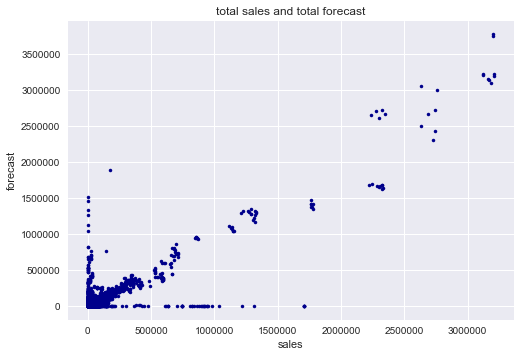

In [106]:
orders=orders.sort_values('sales_9_month',ascending = True)
plt.plot((orders.sales_9_month), orders.forecast_9_month,".",color='darkblue')
plt.title('total sales and total forecast')
plt.xlabel('sales')
plt.ylabel('forecast')
plt.show()


We should find out where actually the forecast was not right so that caused backorder?
because when saes go up forecast also should go up????


## How predictable are sales?


C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
C:\Users\Hedi\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


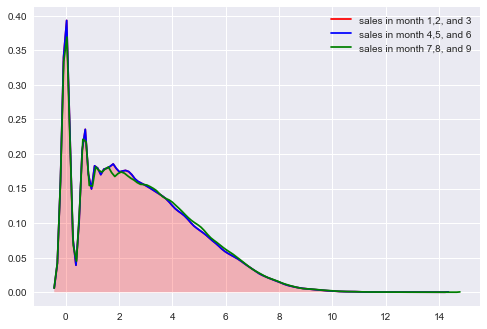

In [107]:
#use hypothesis testing that sales doesnt effect backorder
df_sales=orders
sales123=df_sales.sales_3_month
sales456=df_sales.sales_6_month-df_sales.sales_3_month
sales789=df_sales.sales_9_month-df_sales.sales_6_month

df_sales['sales123']=sales123
df_sales['sales456']=sales456
df_sales['sales789']=sales789

df_sales.head()

sns.kdeplot(np.log(sales123),color='r', shade=True,label='sales in month 1,2, and 3')
sns.kdeplot(np.log(sales123),color='b', shade=False,label='sales in month 4,5, and 6')
sns.kdeplot(np.log(sales789),color='g', shade=False,label='sales in month 7,8, and 9')
plt.show()
